原创教程，版权所有。

同济子豪兄B站视频专栏：https://space.bilibili.com/1900783

玩转UCI心脏病二分类数据集，课件、代码、答疑互动：https://t.zsxq.com/Z7yNZBu

子豪兄Python交流QQ群：1077638784

子豪兄Kaggle数据科学竞赛交流：481041896

微信公众号：人工智能小技巧

2020-05-15


# 本节概述

使用shap机器学习可解释性分析工具包，对uci心脏病数据集上训练得到的随机森林分类模型进行可解释性分析。

绘制单一样本的决策瀑布图、决策图、所有样本的决策图、被分类错误样本的决策图、特征两两关系决策图、单一样本某一特征变化的决策图，找到受某一特征影响最大的样本。

赋予机器学习模型可解释性，打破机器学习模型的黑箱子，让我们能更加充分了解模型、改进模型、信任模型，并对每一个数据样本构建精准定制的数学模型。

# 构建数据集、训练模型、对测试集样本预测

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

# 导入数据集，划分特征和标签
df = pd.read_csv('process_heart.csv')
X = df.drop('target',axis=1)
y = df['target']

# 划分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# 构建随机森林模型
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=5, n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred_proba = model.predict_proba(X_test)

# 计算shap值

In [2]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [3]:
shap_values[1].shape

(61, 26)

In [4]:
expected_value = explainer.expected_value

In [5]:
expected_value

array([0.42566116, 0.57433884])

# 前课回顾

In [6]:
# 完整代码

# 选取完整数据集中索引为idx的样本
idx = 126

patient = X.iloc[idx,:]
patient_df = X.loc[idx:idx]
model_predict_proba = model.predict_proba(patient_df)[0][1]
print('{}号病人的真实标签是 {} ，模型预测为 {:.2f} '.format(idx, bool(y_test[idx]), model_predict_proba))

shap_values_patient = explainer.shap_values(patient)
shap.force_plot(explainer.expected_value[1], shap_values_patient[1], patient)

126号病人的真实标签是 True ，模型预测为 0.78 


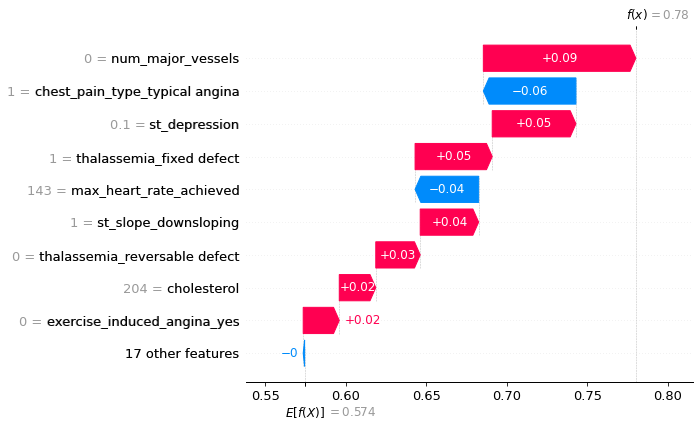

In [7]:
idx = 126
patient = X.loc[idx,:]
shap_values_patient = explainer.shap_values(patient)
shap.waterfall_plot(explainer.expected_value[1], shap_values_patient[1], patient)

# 决策图：Decision Plot

瀑布图只能展示单个数据的决策过程，决策图可以展示测试集所有数据的决策过程。

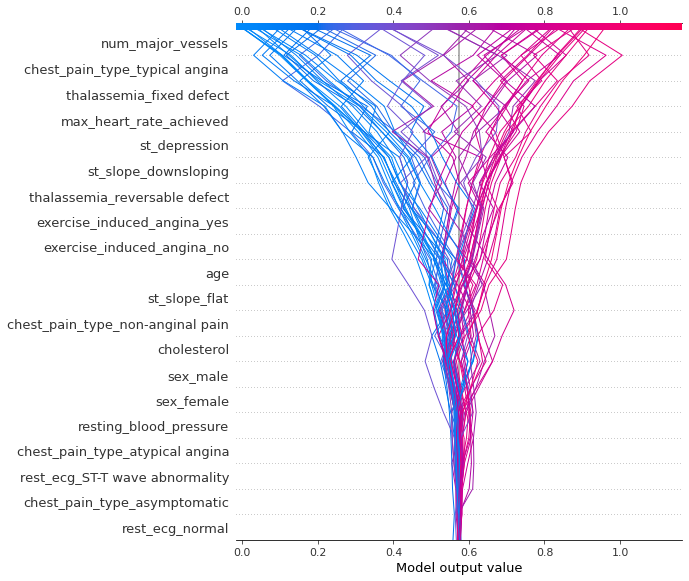

In [8]:
shap.decision_plot(expected_value[1], shap_values[1], X_test)

# 查看典型决策路径与异常点

加`feature_order='hclust'`参数，

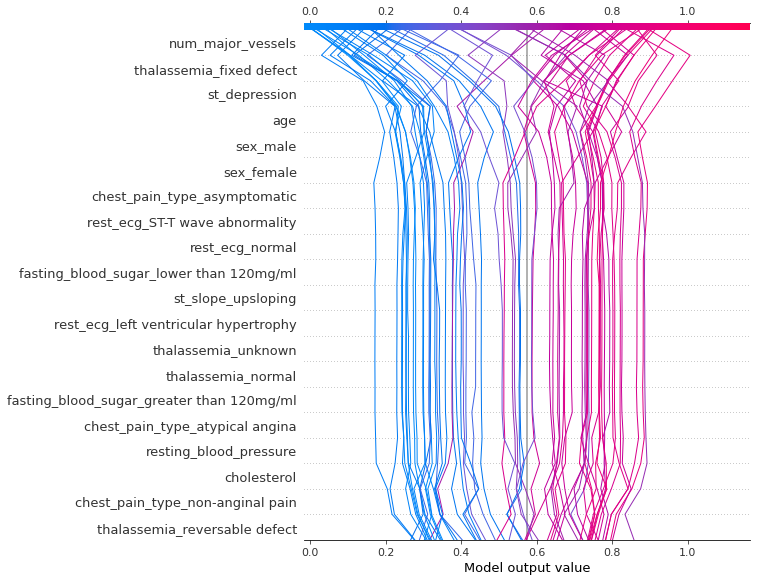

In [9]:
shap.decision_plot(expected_value[1], shap_values[1], X_test, feature_order='hclust')

加`link='logit'`参数，进行对数几率缩放变换。

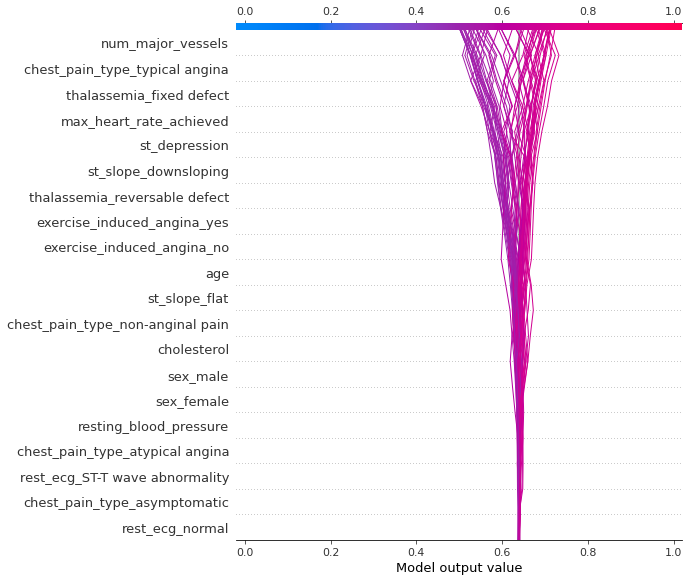

In [10]:
shap.decision_plot(expected_value[1], shap_values[1], X_test, link='logit')

# 绘制单个样本的决策图

索引号为 24 的样本，在原始数据集X中的索引号为 202 


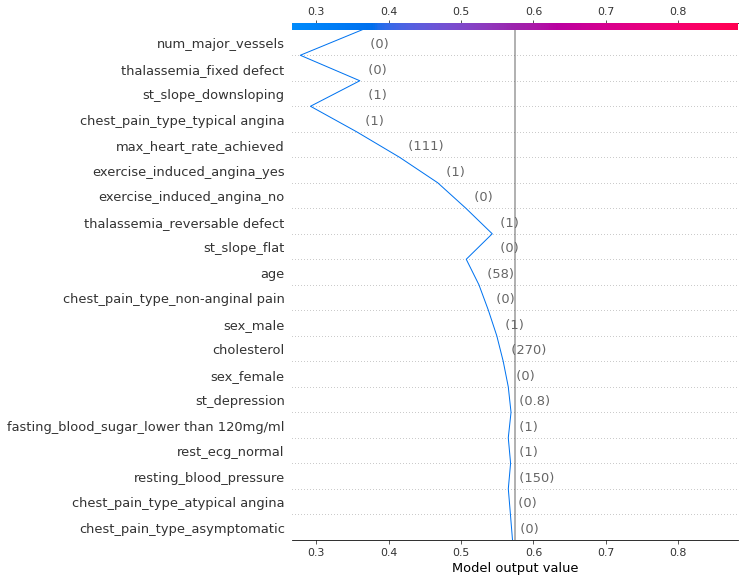

In [11]:
idx = 24
selection = np.zeros((61))
selection[idx] = 1
selection = selection > 0

print('索引号为 {} 的样本，在原始数据集X中的索引号为 {} '.format(idx,X_test.iloc[idx:idx+1].index[0]))

shap.decision_plot(expected_value[1], shap_values[1][selection], X_test[selection])

# 自定义决策图特征显示顺序

In [12]:
X_test.shape

(61, 26)

In [13]:
feature_idx = [i for i in range(26)]

In [14]:
feature_idx

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25]

索引号为 25 的样本，在原始数据集X中的索引号为 240 


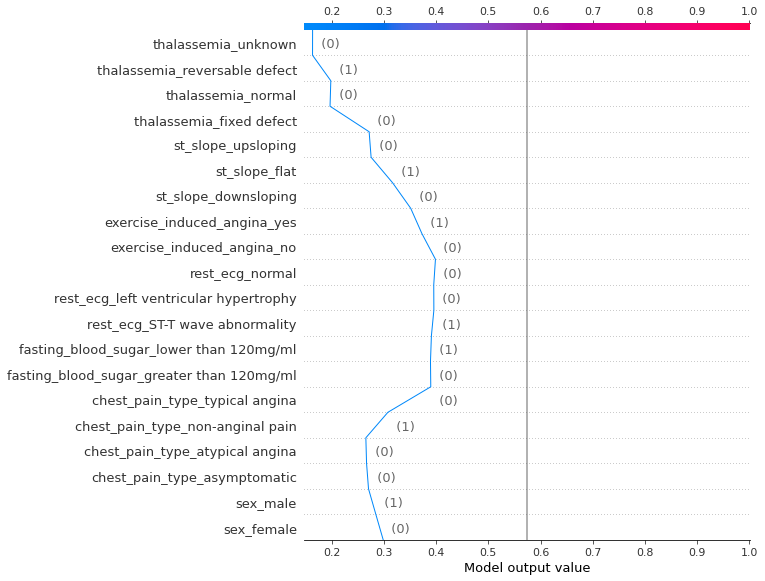

In [15]:
idx = 25
selection = np.zeros((61))
selection[idx] = 1
selection = selection > 0

print('索引号为 {} 的样本，在原始数据集X中的索引号为 {} '.format(idx,X_test.iloc[idx:idx+1].index[0]))
shap.decision_plot(expected_value[1], shap_values[1][selection], X_test[selection], feature_order=feature_idx)

# 选出测试集中模型预测错误的样本

In [16]:
misclassified = y_pred != y_test
misclassified_df = pd.DataFrame({'是否预测错误':misclassified})

In [17]:
misclassified_df

是否预测错误
246   False
183   False
229   False
126   False
184   False
..      ...
277    True
121   False
187   False
301   False
283    True

[61 rows x 1 columns]

In [18]:
misclassified_df = misclassified_df[misclassified_df['是否预测错误'] == True]

In [19]:
misclassified_df

是否预测错误
194    True
296    True
139    True
287    True
52     True
138    True
270    True
188    True
259    True
106    True
173    True
277    True
283    True

In [20]:
misclassified_df.shape

(13, 1)

In [21]:
# force plot完整代码

# 选取完整数据集中索引为idx的样本
idx = 194

patient = X.iloc[idx,:]
patient_df = X.loc[idx:idx]
model_predict_proba = model.predict_proba(patient_df)[0][1]
print('{}号病人的真实标签是 {} ，模型预测为 {:.2f} '.format(idx, bool(y_test[idx]), model_predict_proba))

shap_values_patient = explainer.shap_values(patient)
shap.force_plot(explainer.expected_value[1], shap_values_patient[1], patient)

194号病人的真实标签是 False ，模型预测为 0.73 


In [22]:
# force plot完整代码

# 选取完整数据集中索引为idx的样本
idx = 139

patient = X.iloc[idx,:]
patient_df = X.loc[idx:idx]
model_predict_proba = model.predict_proba(patient_df)[0][1]
print('{}号病人的真实标签是 {} ，模型预测为 {:.2f} '.format(idx, bool(y_test[idx]), model_predict_proba))

shap_values_patient = explainer.shap_values(patient)
shap.force_plot(explainer.expected_value[1], shap_values_patient[1], patient)

139号病人的真实标签是 True ，模型预测为 0.09 


# 在决策图中显示测试集中模型预测错误的样本

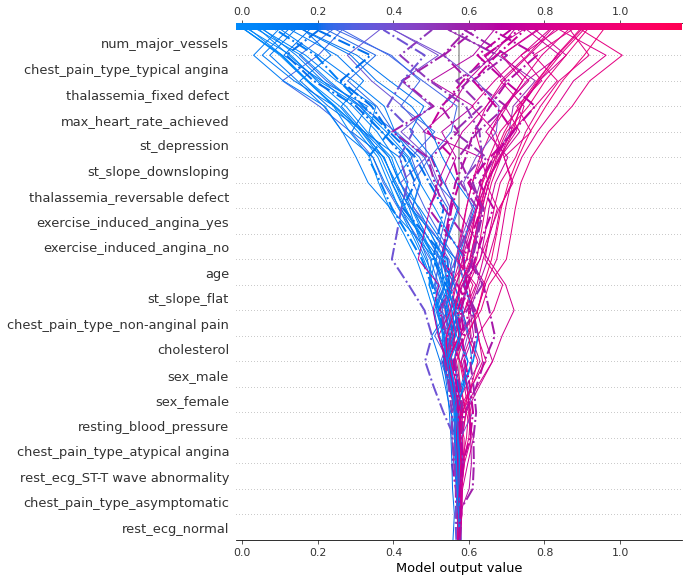

In [23]:
shap.decision_plot(expected_value[1], shap_values[1], X_test, highlight=misclassified)

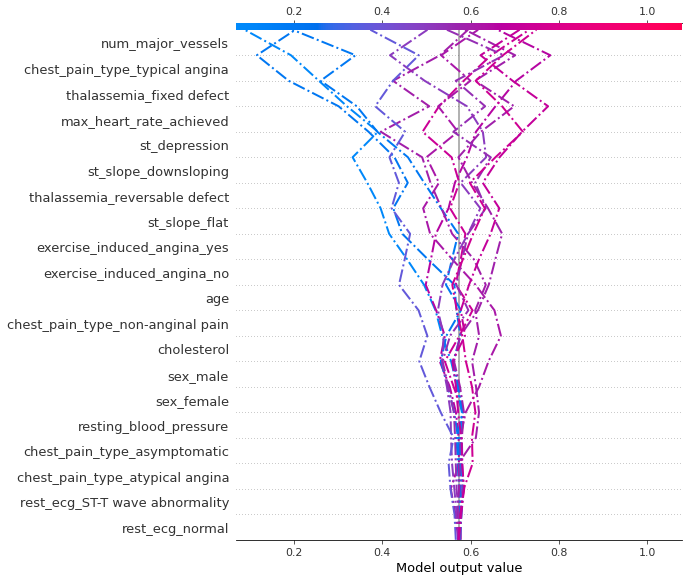

In [24]:
shap.decision_plot(expected_value[1], shap_values[1][misclassified], X_test[misclassified], highlight=range(len(misclassified_df)))

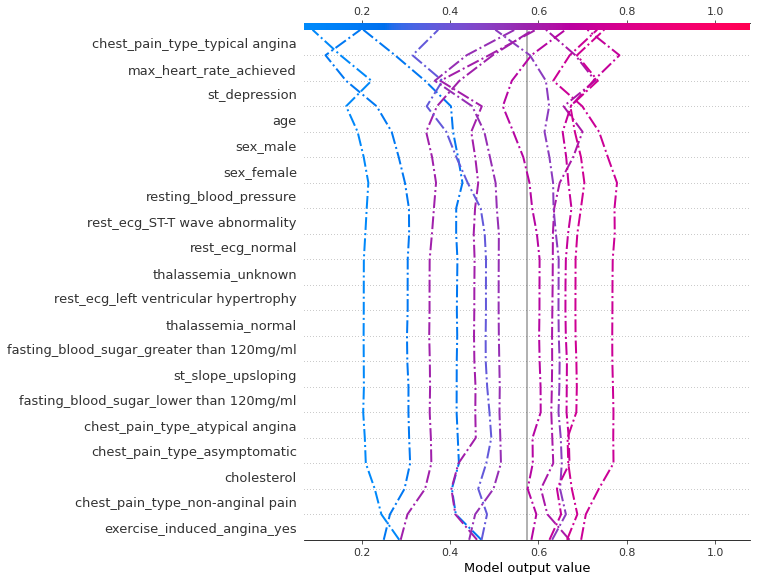

In [25]:
shap.decision_plot(expected_value[1], shap_values[1][misclassified], X_test[misclassified], highlight=range(len(misclassified_df)),feature_order='hclust')

红线表示没患病的病人被模型错误分类为患病，蓝线表示患病病人被模型错误分类为不患病。

# 两两交互特征对预测结果影响

主对角线的图与summary plot相同。

其它的图中，红色表示两个特征的值都较高，蓝色表示两个特征的值都较低。

每个图里，越靠右的点表示这一对两两交互特征对预测为“患病”的结果有正向影响。

In [26]:
shap_interaction_values = explainer.shap_interaction_values(X_test)

In [27]:
shap_interaction_values[1].shape

(61, 26, 26)

In [28]:
shap_interaction_values[0].shape

(61, 26, 26)

In [29]:
shap_interaction_values[1].shape

(61, 26, 26)

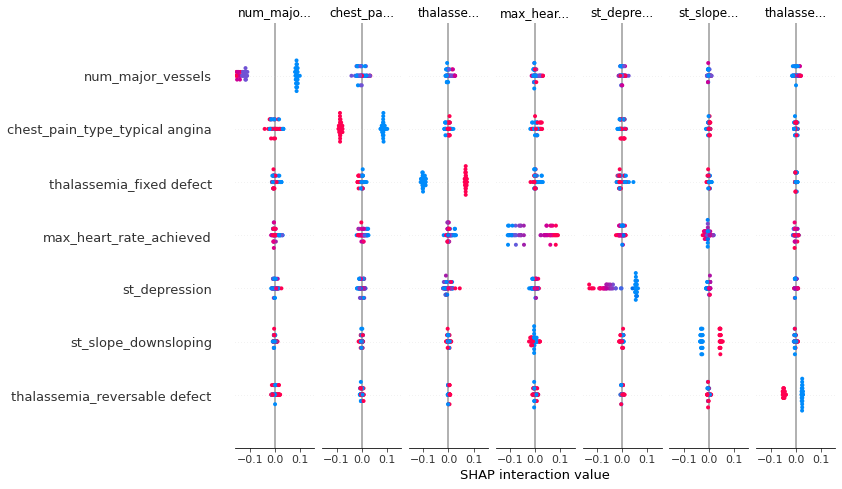

In [30]:
shap.summary_plot(shap_interaction_values[1],X_test)

选出测试集中索引为5的样本的变量交互shap值矩阵

In [31]:
shap_interaction_values[1][5].shape

(26, 26)

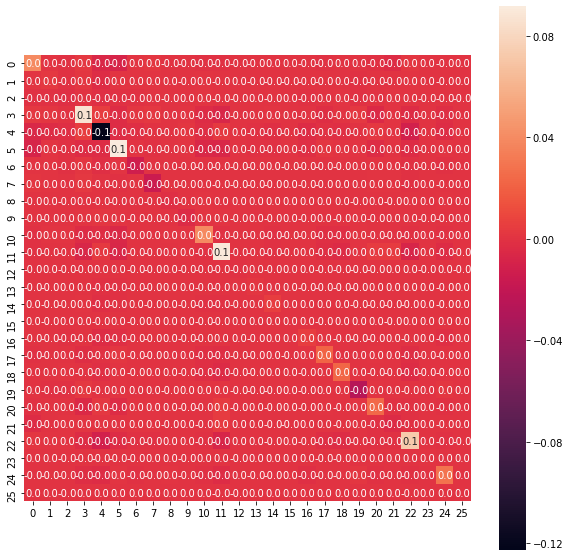

In [32]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(shap_interaction_values[1][5],annot=True,fmt='.1f',square=True)
plt.show()

# 考虑两两交互特征的决策图

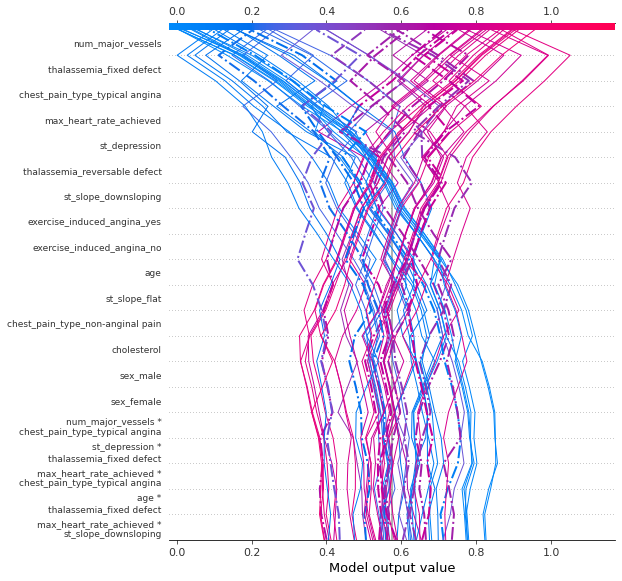

In [33]:
shap.decision_plot(expected_value[1], shap_interaction_values[1], X_test, highlight=misclassified)

如果特证数量过多，可以用feature_display_range参数调节展示的特征个数

slice(None, -101, -1)为展示100个特征

slice(None, None, -1)为展示所有特征（绘制很长的竖图）

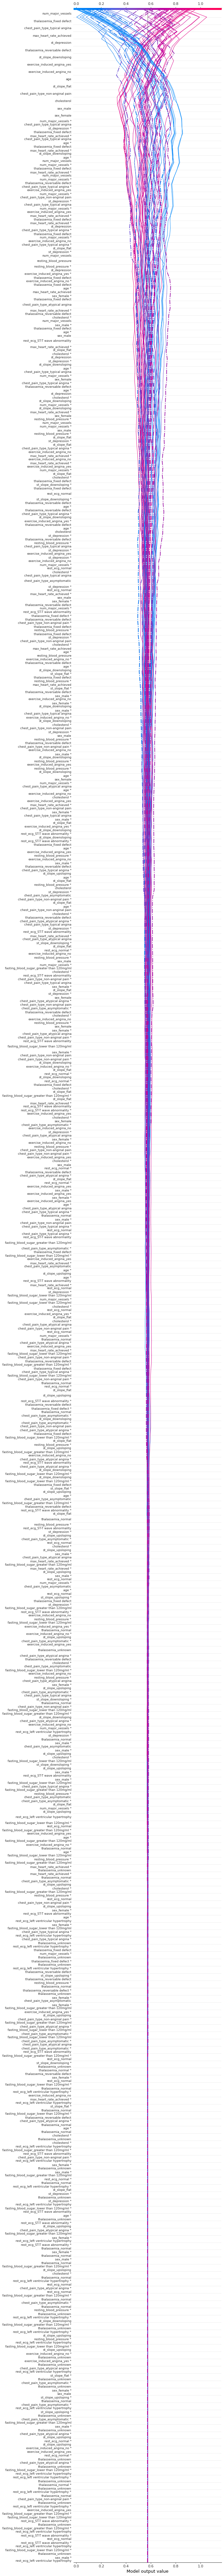

In [34]:
shap.decision_plot(expected_value[1], shap_interaction_values[1], X_test, highlight=misclassified, feature_display_range=slice(None, None, -1), ignore_warnings=True)

# 考虑两两交互特征的单个样本决策图

索引号为 24 的样本，在原始数据集X中的索引号为 202 


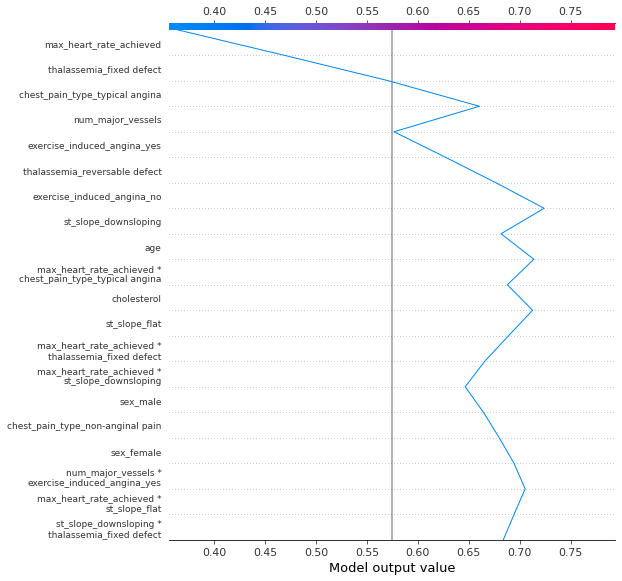

In [35]:
idx = 24
selection = np.zeros((61))
selection[idx] = 1
selection = selection > 0

print('索引号为 {} 的样本，在原始数据集X中的索引号为 {} '.format(idx,X_test.iloc[idx:idx+1].index[0]))

shap.decision_plot(expected_value[1], shap_interaction_values[1][selection], X_test[selection])

索引号为 24 的样本，在原始数据集X中的索引号为 202 


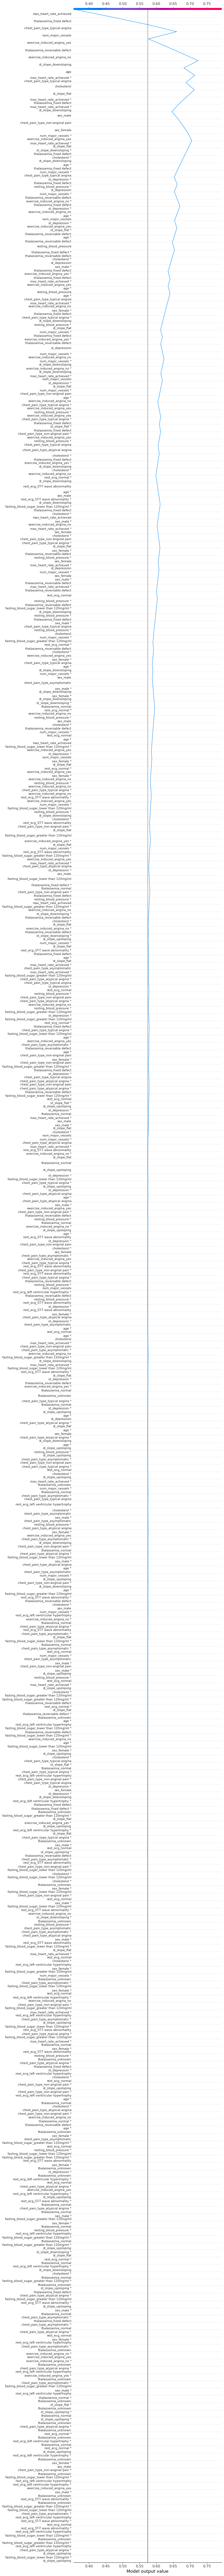

In [36]:
idx = 24
selection = np.zeros((61))
selection[idx] = 1
selection = selection > 0

print('索引号为 {} 的样本，在原始数据集X中的索引号为 {} '.format(idx,X_test.iloc[idx:idx+1].index[0]))

shap.decision_plot(expected_value[1], shap_interaction_values[1][selection], X_test[selection], feature_display_range=slice(None, None, -1), ignore_warnings=True)

# 25号病人某一特征变化对模型分类结果的影响

In [37]:
idx = 25
X_test.loc[idx]

age                                           71.0
resting_blood_pressure                       160.0
cholesterol                                  302.0
max_heart_rate_achieved                      162.0
st_depression                                  0.4
num_major_vessels                              2.0
sex_female                                     1.0
sex_male                                       0.0
chest_pain_type_asymptomatic                   0.0
chest_pain_type_atypical angina                1.0
chest_pain_type_non-anginal pain               0.0
chest_pain_type_typical angina                 0.0
fasting_blood_sugar_greater than 120mg/ml      0.0
fasting_blood_sugar_lower than 120mg/ml        1.0
rest_ecg_ST-T wave abnormality                 1.0
rest_ecg_left ventricular hypertrophy          0.0
rest_ecg_normal                                0.0
exercise_induced_angina_no                     1.0
exercise_induced_angina_yes                    0.0
st_slope_downsloping           

In [38]:
print('索引号为 {} 的样本，在原始数据集X中的索引号为 {} '.format(idx,X_test.iloc[idx:idx+1].index[0]))

索引号为 25 的样本，在原始数据集X中的索引号为 240 


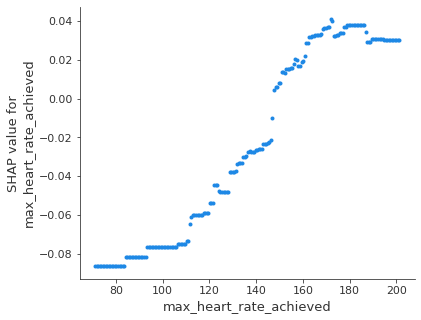

In [39]:
feature_selected = 'max_heart_rate_achieved'
sep = 200
feature_selected_min = X[feature_selected].min()
feature_selected_max = X[feature_selected].max()
step = (feature_selected_max - feature_selected_min)/sep
rg = np.arange(feature_selected_min, feature_selected_max, step)
R = X.iloc[np.repeat(idx, len(rg))].reset_index(drop=True)
R[feature_selected] = rg
hypothetical_shap_values = explainer.shap_values(R)[1]
shap.dependence_plot(feature_selected, hypothetical_shap_values, R, interaction_index=None)

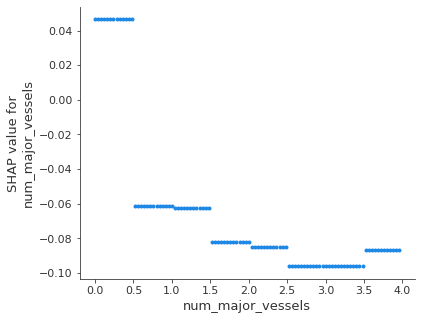

In [40]:
feature_selected = 'num_major_vessels'
sep = 100
feature_selected_min = X[feature_selected].min()
feature_selected_max = X[feature_selected].max()
step = (feature_selected_max - feature_selected_min)/sep
rg = np.arange(feature_selected_min, feature_selected_max, step)
R = X.iloc[np.repeat(idx, len(rg))].reset_index(drop=True)
R[feature_selected] = rg
hypothetical_shap_values = explainer.shap_values(R)[1]
shap.dependence_plot(feature_selected, hypothetical_shap_values, R, interaction_index=None)

# 绘制25号病人某特征不同变化范围的决策图

In [41]:
hypothetical_shap_values.shape

(100, 26)

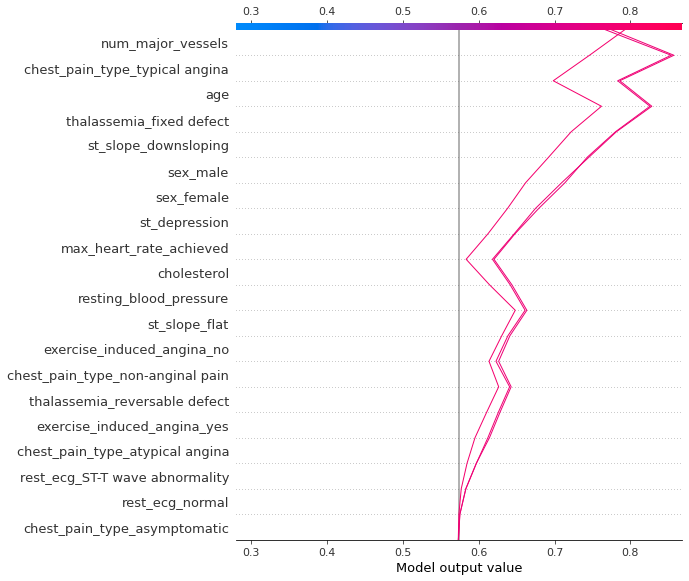

In [42]:
idx = 25
shap.decision_plot(expected_value[1], hypothetical_shap_values[[0,50,99]], X_test.iloc[idx], feature_order='importance')

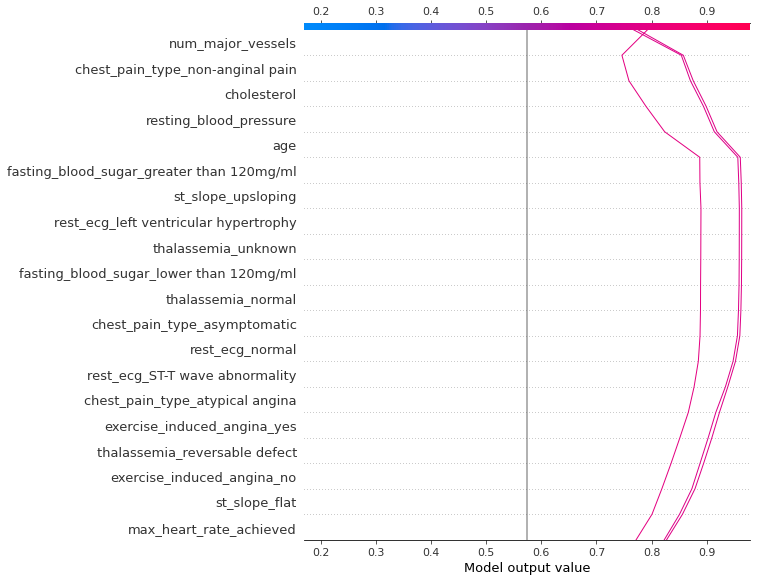

In [43]:
shap.decision_plot(expected_value[1], hypothetical_shap_values[[0,50,99]], X_test.iloc[idx], feature_order='hclust')

# 25号病人的地中海贫血症特征不同值对模型分类结果的影响

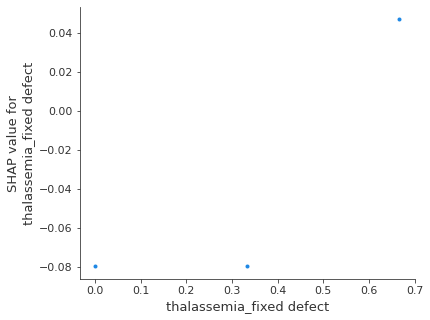

In [44]:
feature_selected = 'thalassemia_fixed defect'
sep = 3
feature_selected_min = X[feature_selected].min()
feature_selected_max = X[feature_selected].max()
step = (feature_selected_max - feature_selected_min)/sep
rg = np.arange(feature_selected_min, feature_selected_max, step)
# rg = range(feature_selected_min, feature_selected_max, int(step))
R = X.iloc[np.repeat(idx, len(rg))].reset_index(drop=True)
R[feature_selected] = rg
hypothetical_shap_values = explainer.shap_values(R)[1]
shap.dependence_plot(feature_selected, hypothetical_shap_values, R, interaction_index=None)

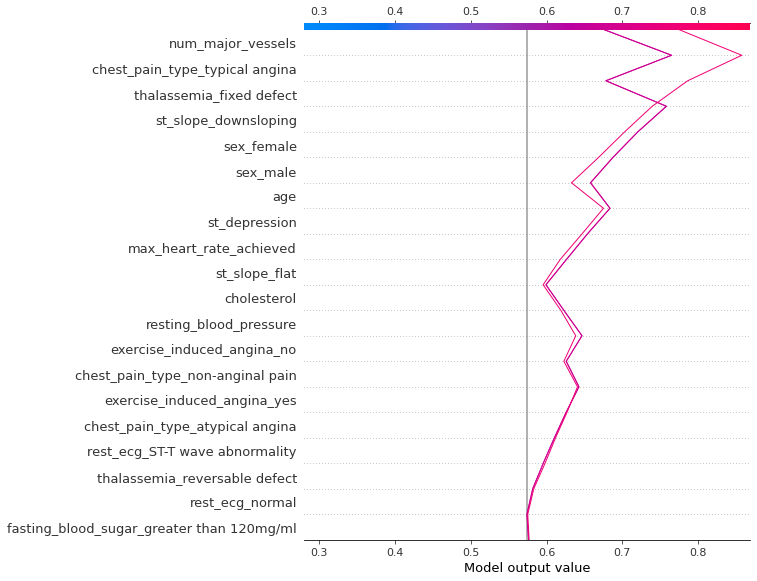

In [45]:
idx = 25
shap.decision_plot(expected_value[1], hypothetical_shap_values[[0,1,2]], X_test.iloc[idx], feature_order='importance')

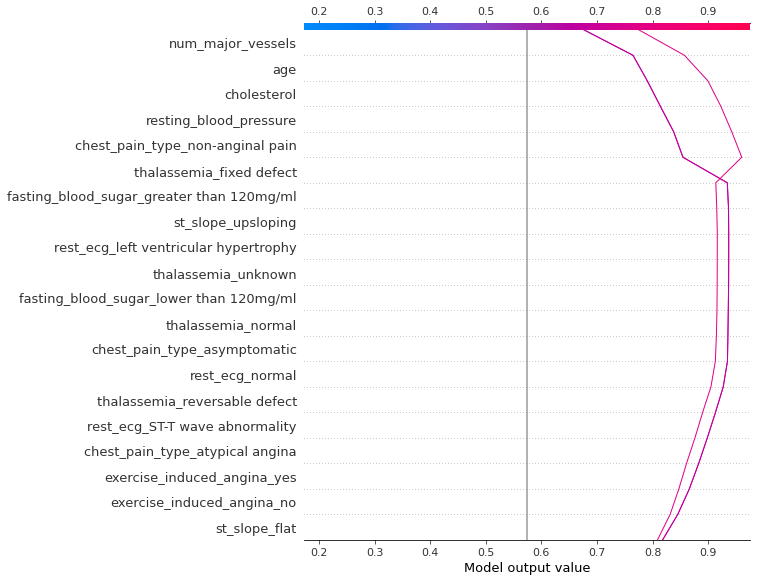

In [46]:
shap.decision_plot(expected_value[1], hypothetical_shap_values, R, feature_order='hclust')

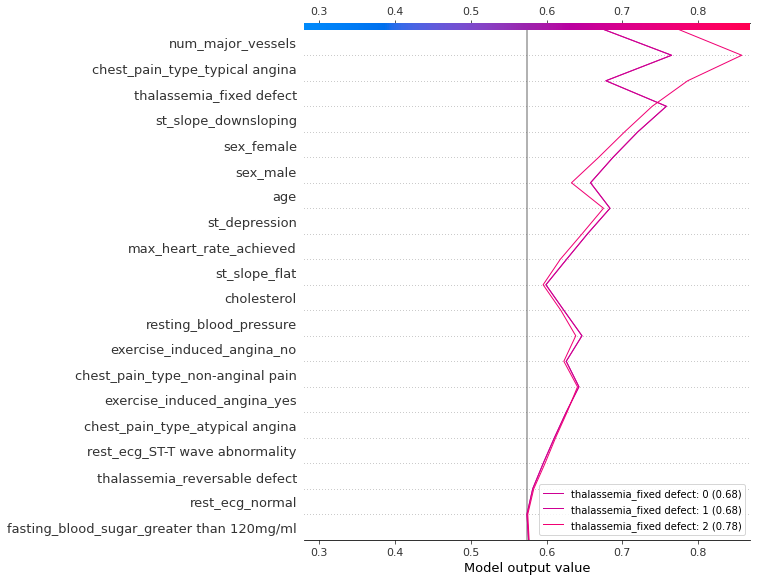

In [47]:
hypothetical_predictions = expected_value[1] + hypothetical_shap_values.sum(axis=1)

def legend_labels(idx):
    return [f'thalassemia_fixed defect: {i:,} ({hypothetical_predictions[i]:.2f})' for i in idx]

show_idx = np.arange(0,3)
shap.decision_plot(expected_value[1], hypothetical_shap_values[show_idx], X, legend_labels=legend_labels(show_idx), legend_location='lower right')

# 找出受st_depression特征影响最大的病人

In [48]:
X_test['st_depression'].unique()

array([1.9, 2.5, 1.8, 0.1, 2.6, 3.5, 0. , 3. , 2. , 1. , 3.4, 1.4, 0.2,
       1.6, 0.8, 2.9, 2.2, 3.6, 1.5, 2.8, 0.4, 3.1, 0.6, 3.8, 3.2, 2.1,
       1.2, 0.3])

In [49]:
idx = np.argpartition(shap_values[1][:, X_test.columns.get_loc('st_depression')], 2)

In [50]:
idx.shape

(61,)

In [51]:
idx

array([ 5, 32, 46,  3,  4,  0,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,  2, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

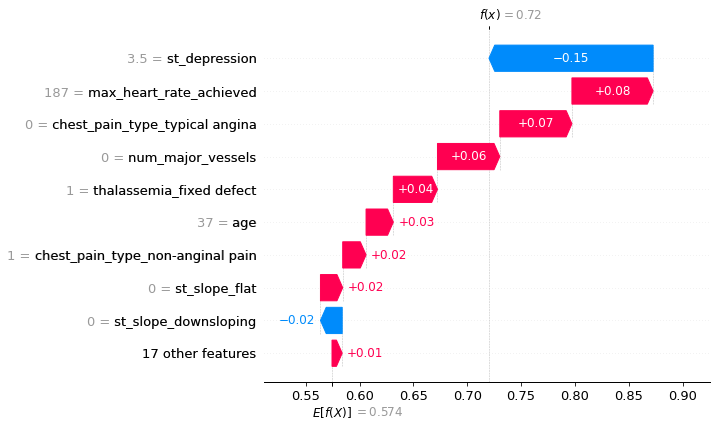

In [52]:
idx = 5
patient = X_test.iloc[idx,:]
shap_values_patient = explainer.shap_values(patient)
shap.waterfall_plot(explainer.expected_value[1], shap_values_patient[1], patient)

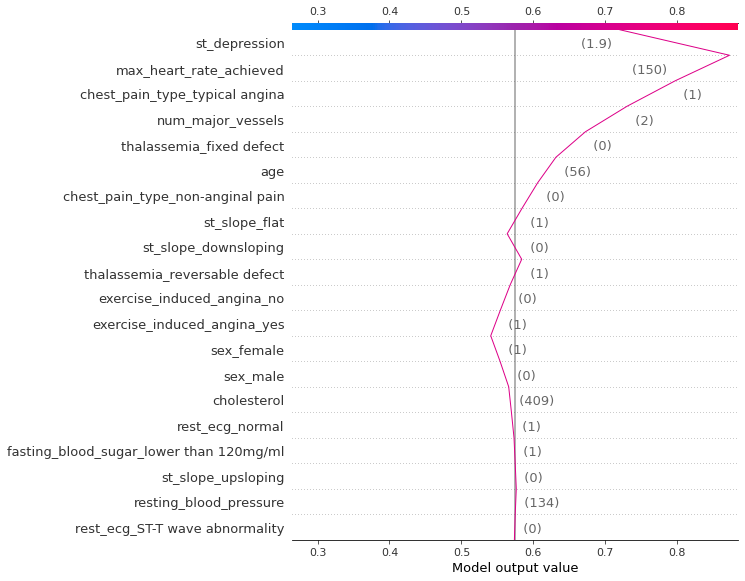

In [53]:
shap.decision_plot(expected_value[1], shap_values[1][5], X_test, feature_order='importance')

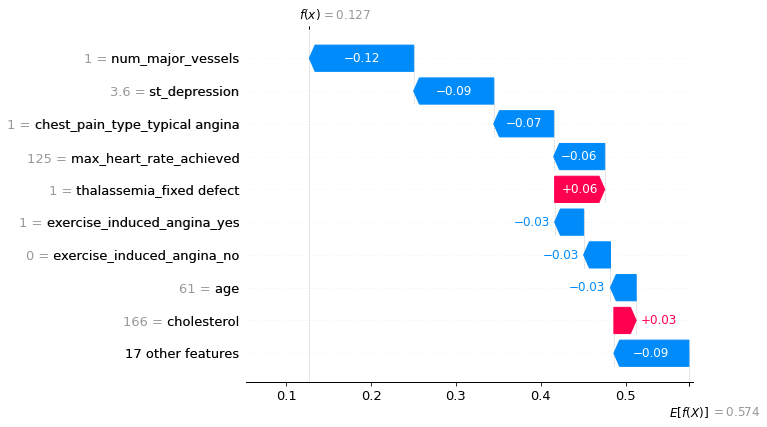

In [54]:
idx = 32
patient = X_test.iloc[idx,:]
shap_values_patient = explainer.shap_values(patient)
shap.waterfall_plot(explainer.expected_value[1], shap_values_patient[1], patient)

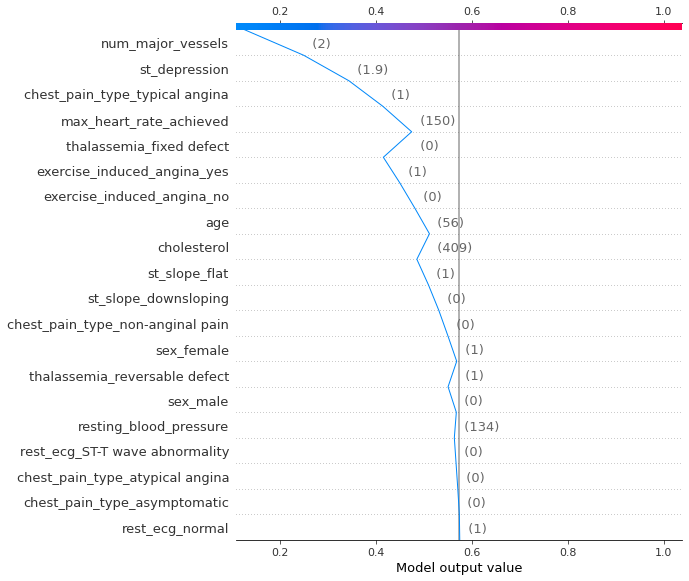

In [55]:
shap.decision_plot(expected_value[1], shap_values[1][32], X_test, feature_order='importance')

# 找出受max_heart_rate_achieved特征影响最大的病人

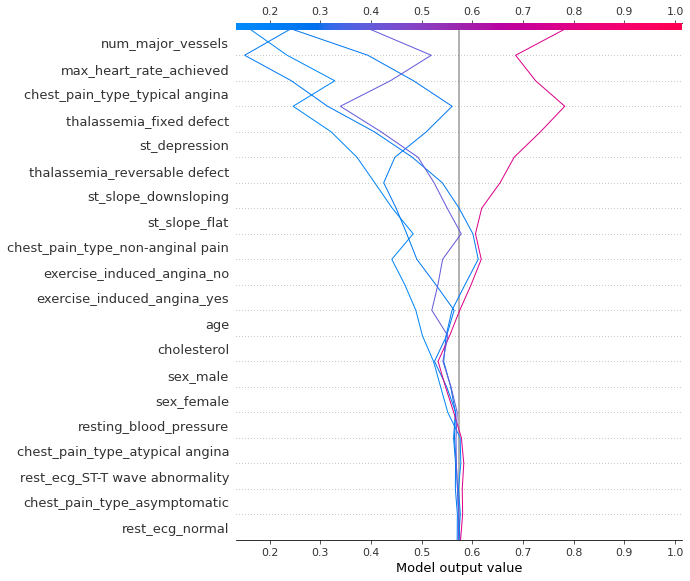

In [56]:
feature = 'max_heart_rate_achieved'
num_show = 5
idx = np.argpartition(shap_values[1][:, X_test.columns.get_loc(feature)], 2)
shap.decision_plot(expected_value[1], shap_values[1][idx[0:num_show]], X_test, feature_order='importance')

# 找出受num_major_vessels特征影响最大的病人¶

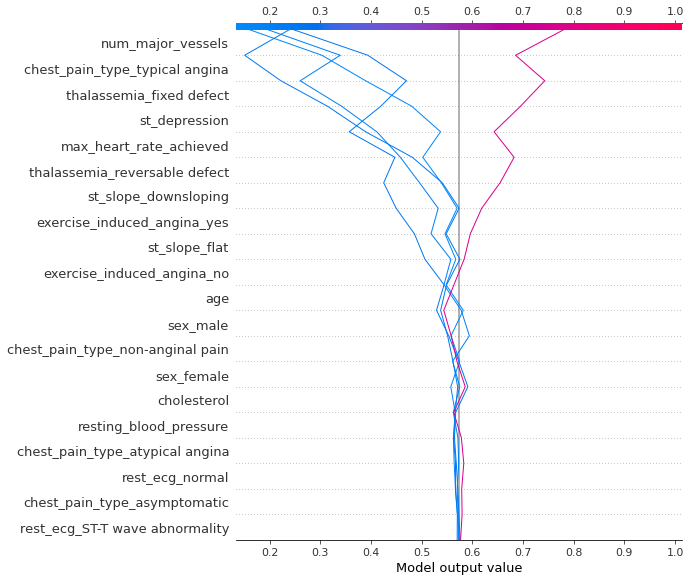

In [57]:
feature = 'num_major_vessels'
num_show = 5
idx = np.argpartition(shap_values[1][:, X_test.columns.get_loc(feature)], 2)
shap.decision_plot(expected_value[1], shap_values[1][idx[0:num_show]], X_test, feature_order='importance')